In [1]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from IPython.display import clear_output 
from sklearn.model_selection import train_test_split

In [2]:
import os
"""
path = 'C:/Users/hrips/OneDrive/Documents/Task/CTPelvic1K/metal/image'
files = os.listdir(path)
for index, file in enumerate(files):
    os.rename(os.path.join(path, file), os.path.join(path, ''.join([str(index), '.png'])))
"""    

"\npath = 'C:/Users/hrips/OneDrive/Documents/Task/CTPelvic1K/metal/image'\nfiles = os.listdir(path)\nfor index, file in enumerate(files):\n    os.rename(os.path.join(path, file), os.path.join(path, ''.join([str(index), '.png'])))\n"

In [3]:
"""
path = 'C:/Users/hrips/OneDrive/Documents/Task/CTPelvic1K/metal/mask'
files = os.listdir(path)
for index, file in enumerate(files):
    os.rename(os.path.join(path, file), os.path.join(path, ''.join([str(index), '.png'])))
    
"""   

"\npath = 'C:/Users/hrips/OneDrive/Documents/Task/CTPelvic1K/metal/mask'\nfiles = os.listdir(path)\nfor index, file in enumerate(files):\n    os.rename(os.path.join(path, file), os.path.join(path, ''.join([str(index), '.png'])))\n    \n"

In [4]:
image_full = os.path.join("C:/Users/hrips/OneDrive/Documents/Task/CTPelvic1K/metal/image")    #1019 images
mask_full = os.path.join("C:/Users/hrips/OneDrive/Documents/Task/CTPelvic1K/metal/mask")      #1019 masks


image_train = os.path.join("C:/Users/hrips/OneDrive/Documents/Task/CTPelvic1K/metal/image_train") # 812 images (80%)
image_test = os.path.join("C:/Users/hrips/OneDrive/Documents/Task/CTPelvic1K/metal/image_test")   # 207 images (20%)

mask_train = os.path.join("C:/Users/hrips/OneDrive/Documents/Task/CTPelvic1K/metal/mask_train") # 812 images (80%)
mask_test = os.path.join("C:/Users/hrips/OneDrive/Documents/Task/CTPelvic1K/metal/mask_test")  # 207 images (20%)


In [5]:
images = os.listdir(image_full)
mask = os.listdir(mask_full)

### Visualization of renamed images with their masks

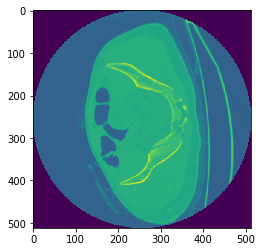

In [6]:
img_array = np.array(Image.open("C:/Users/hrips/OneDrive/Documents/Task/CTPelvic1K/metal/image_train/220.png"))
plt.imshow(img_array)

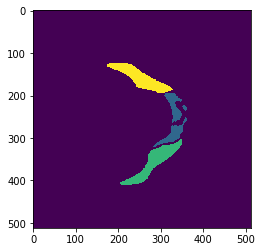

In [7]:
mask_array = np.array(Image.open('C:/Users/hrips/OneDrive/Documents/Task/CTPelvic1K/metal/mask_train/220.png'))
plt.imshow(mask_array)

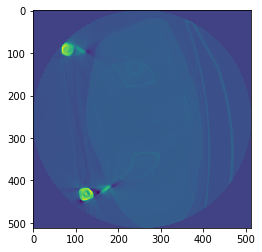

In [8]:
img_array = np.array(Image.open("C:/Users/hrips/OneDrive/Documents/Task/CTPelvic1K/metal/image_test/175.png"))
plt.imshow(img_array)

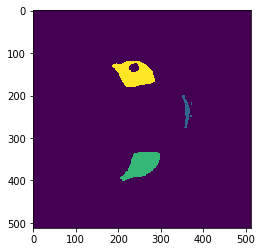

In [9]:
img_array = np.array(Image.open("C:/Users/hrips/OneDrive/Documents/Task/CTPelvic1K/metal/mask_test/175.png"))
plt.imshow(img_array)

In [10]:
training_files = set(os.listdir(image_train)) & set(os.listdir(mask_train))
testing_files = set(os.listdir(image_test)) & set(os.listdir(mask_test))

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_test,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_test,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_train,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join (mask_train,i)),(X_shape,X_shape)) [:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [11]:
#perform sanity check

def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [12]:
# Load training and testing data
dim = 240*2
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim, flag="test")

100%|███████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 345.92it/s]


training set


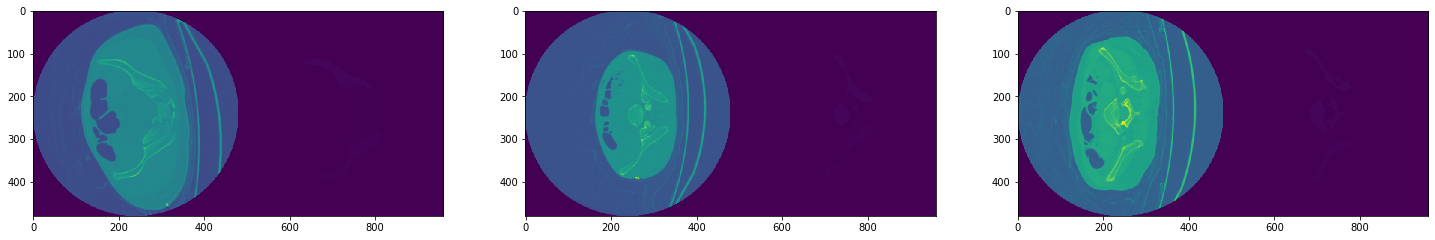

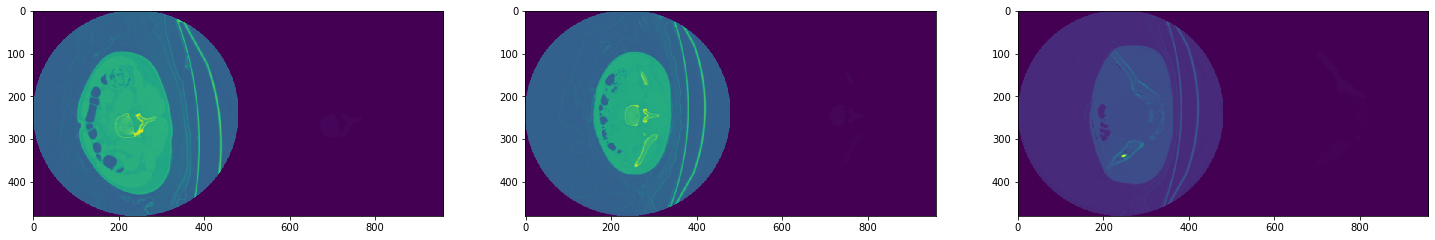

In [13]:
print("training set")
plotMask(X_train,y_train)

testing set


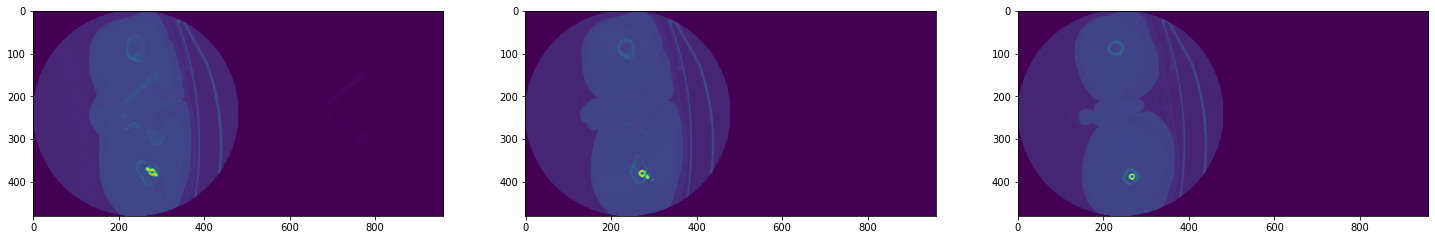

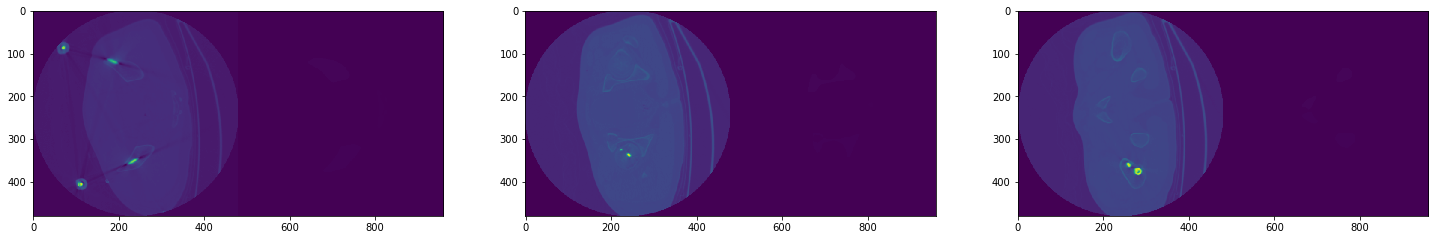

In [14]:
print("testing set")
plotMask(X_test,y_test)

### Combine training-testing sets and use them as a unified dataset

In [15]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

### Define a semantic segmentation U-Net network and callbacks

In [16]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(104,104,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(30, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(30, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(60, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(60, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(120, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(120, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(240, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(240, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(480, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(480, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(240, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(240, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(240, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(120, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(120, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(120, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(60, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(60, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(60, (3, 3), activation='relu', padding='same')(conv8)
    
    up9 = concatenate([Conv2DTranspose(30, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(30, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(30, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

### Compile and train the U-Net Model

In [17]:
model = unet(input_size=(480,480,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 480, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 480, 480, 30) 300         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 480, 30) 8130        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 240, 240, 30) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

c:\users\hrips\appdata\local\programs\python\python37\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Callbacks, Early Stopping and Reduced LR

In [18]:
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

### Train the Model

In [19]:
model.compile(optimizer=Adam(lr=2e-4), 
              loss=[dice_coef_loss], 
              metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

loss_history = model.fit(x = train_vol,
                         y = train_seg,
                         batch_size = 16,
                         epochs = 30,
                         validation_data =(test_vol,test_seg) ,
                         callbacks=callbacks_list)


clear_output()


### Plot the Metric and Evaluate

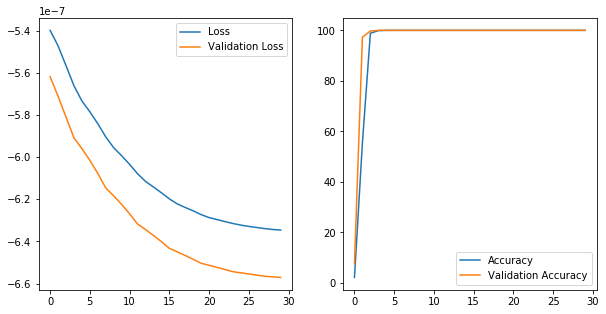

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

### Test the model

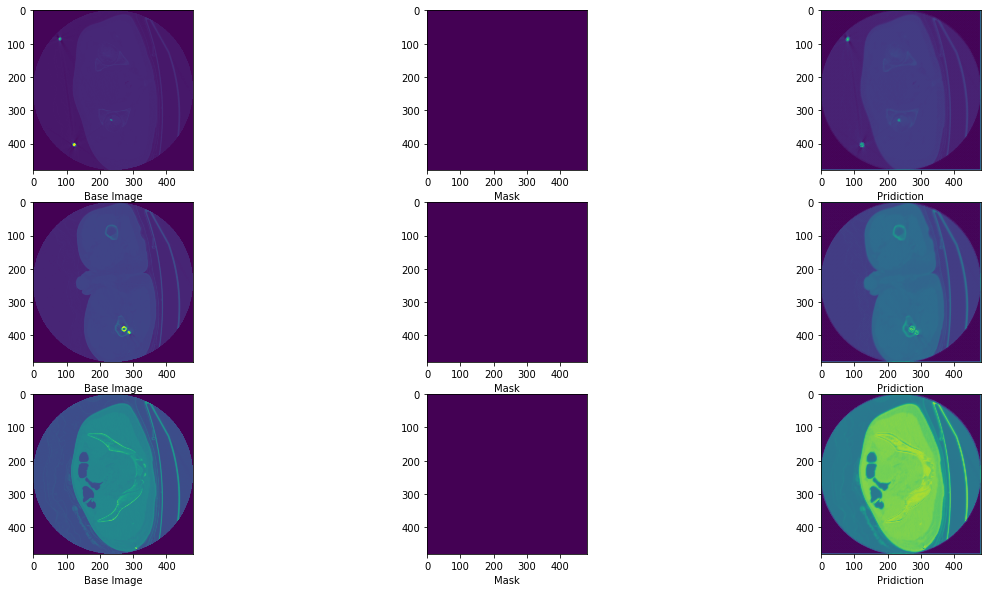

In [21]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")